CRNN : CNN + RNN
  - CNN : 이미지에서 특징을 추출하고 추출된 특징을 RNN에 넣어서 글자를 예측
  - CTC손실 : 결과가 다양한 방법으로 표현이 가능할때 사용하는 손실, 가능한 모든경로의 확률의 합을 확률로 표현


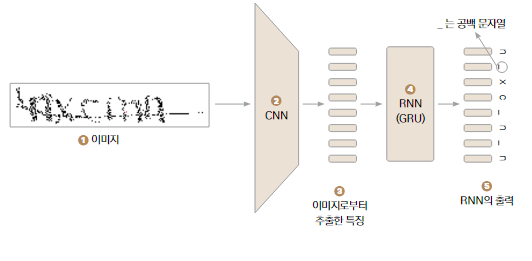

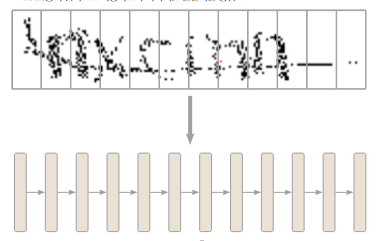

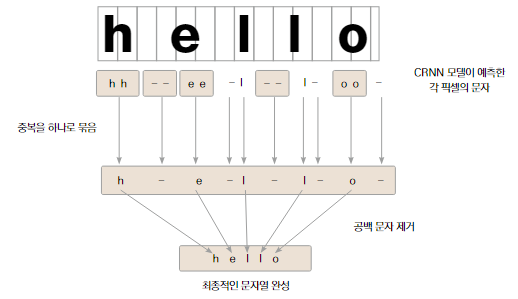

In [1]:
# ctc 손실

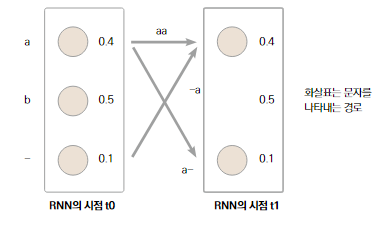

In [2]:
# aa 확률 : 0.4*0.4 \ 0.16
# a- 확률: 0.4*0.1 \ 0.04
# -a 확률: 0.1*0.4 \ 0.04
# 다 더하면.. 0.24의 확률 24%로 a를 타나내고 있음

In [3]:
# CTC 손실이 최소화  되도록 학습

In [4]:
# 데이터  https://www.kaggle.com/datasets/fournierp/captcha-version-2-images

In [ ]:
!unzip '/content/drive/MyDrive/캡차/archive.zip'

In [6]:
import string
import matplotlib.pyplot as plt
import glob
import tqdm
from PIL import Image

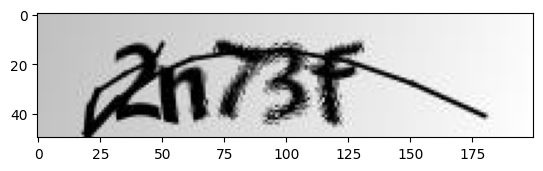

In [7]:
imgfiles = glob.glob("/content/samples/*.png")
imgfile =  Image.open(imgfiles[0])
plt.imshow(imgfile)
plt.show()

In [8]:
imgfiles[0]

'/content/samples/2n73f.png'

In [9]:
# png 파일은 rgb, 투명도를나타내는 알파채널이 있음

In [10]:
# 파일이름의 확장자를 제거.. ->정답
# 정답에 등장하는 모든 문자에대한 BOW를 생성
import numpy as np
from torch.utils.data.dataset import Dataset

In [11]:
def get_BOW(corpus):
  # 공백문자 <pad>를 0으로 설정
  BOW = {"<pad>" : 0}
  # 고유번호 추가
  for latter in corpus:
    if latter not in BOW:
      BOW[latter] = len(BOW.keys())
  return BOW

In [12]:
get_BOW(["aa",'bb','cc','bb'])

{'<pad>': 0, 'aa': 1, 'bb': 2, 'cc': 3}

In [67]:
# 데이터 셋
class Capcha(Dataset):
  def __init__(self,pth,train=True):
    # 소문자와 숫자만 정답으로 설정
    self.corpus = string.ascii_lowercase + string.digits  # abcdefghijklmnopqrstuvwxyz0123456789
    self.BOW = get_BOW(self.corpus)

    self.imgfiles = glob.glob(pth + "/*.png")

    self.train = train
    split_rate = int(len(self.imgfiles)*0.8)
    self.trainset = self.imgfiles[ : split_rate ]
    self.testset = self.imgfiles[split_rate : ]
  # 챕차의 문자를 고유 번호로 변경
  def get_seq(self, line):
    label = []
    for latter in line:
      label.append(self.BOW[latter])
    return label
  def __len__(self):
    if self.train:
      return len(self.trainset)
    else:
      return len(self.testset)
  def __getitem__(self, index):
    if self.train:
      # png파일을 rgb 파일로 변환
      data = Image.open(self.trainset[index]).convert("RGB")
      label = self.trainset[index].split("/")[-1]
      # 확장자 제거
      label = label.split('.')[0]
      # 정답을 BOW의 순열로 변환
      label = self.get_seq(label)

      data = np.array(data).astype(np.float32)
      # 파이토치 채녈이 가장 앞에 와야 함
      data = np.transpose(data,(2,0,1))
      label = np.array(label)
      return data, label
    else:
      data = Image.open(self.testset[index]).convert("RGB")
      label = self.testset[index].split("/")[-1]
      label = label.split('.')[0]
      label = self.get_seq(label)

      data = np.array(data).astype(np.float32)
      label = np.array(label)
      return data, label

In [68]:
# Resnet 구조로 CNN 설계
# 캡차는 기존 이미지크기와 다르게 가로픽셀이 세로보다 많은 직사각형--> 커널의 모양도 가로의 길이가 더 크게
# 최종적으로  RNN의 입력으로 들어가야 함 세로방향의 픽셀이 1개만 존재

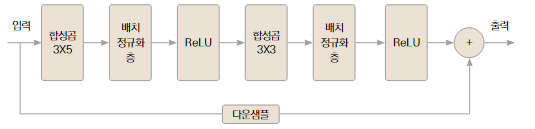

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# 3x5 크기의 커널을 사용
# 3x5는 긴 형태의 객체를 탐지하는데 도움

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 3X5 크기의 커널을 이용
class BasicBlock(nn.Module):
   def __init__(self,
                in_channels,
                out_channels,
                kernel_size=(3, 5),
                stride=(2, 1)):
       super(BasicBlock, self).__init__()

       self.c1 = nn.Conv2d(in_channels=in_channels,
                           out_channels=out_channels,
                           kernel_size=kernel_size,
                           stride=stride)
       self.c2 = nn.Conv2d(in_channels=out_channels,
                           out_channels=out_channels,
                           kernel_size=(3, 3), padding=1)

       self.downsample = nn.Conv2d(in_channels=in_channels,
                                   out_channels=out_channels,
                                   kernel_size=kernel_size,
                                   stride=stride)

       self.bn1 = nn.BatchNorm2d(num_features=out_channels)
       self.bn2 = nn.BatchNorm2d(num_features=out_channels)

       self.relu = nn.ReLU()

   def forward(self, x):
       x_ = x

       x = self.c1(x)
       x = self.bn1(x)
       x = self.relu(x)
       x = self.c2(x)
       x = self.bn2(x)

       x_ = self.downsample(x_)

       x += x_
       x = self.relu(x)

       return x

In [71]:
# CNN으로 부터 얻은 특징은 GRU에 입력하는건 불가능
# GRU는 픽셀간의 순서 정보를 학습
# 파이토치는 이미지를 처리할때 채널 정보가 가장 앞에 온다 - > 채널 정보와 픽셀의 순서를 변경
# GRU의 결과에서 얻어진 텐서는 MLP층을 통해 어떤 글자인지 분류

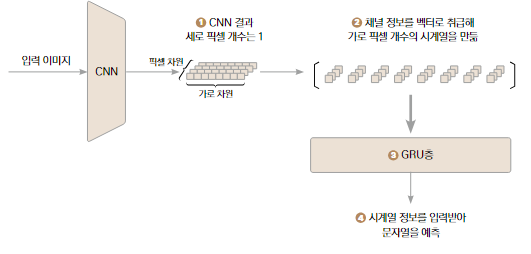

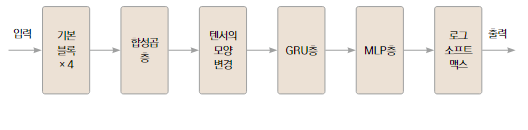

In [72]:
class CRNN(nn.Module):
   def __init__(self, output_size):
       super(CRNN, self).__init__()

       # CNN층의 정의
       self.c1 = BasicBlock(in_channels=3, out_channels=64)
       self.c2 = BasicBlock(in_channels=64, out_channels=64)
       self.c3 = BasicBlock(in_channels=64, out_channels=64)
       self.c4 = BasicBlock(in_channels=64, out_channels=64)
       self.c5 = nn.Conv2d(64, 64, kernel_size=(2, 5))

       # 텍스트 정보를 추출할 GRU층
       self.gru = nn.GRU(64, 64, batch_first=False)

       # 분류를 위한 MLP층
       self.fc1 = nn.Linear(in_features=64, out_features=128)
       self.fc2 = nn.Linear(in_features=128, out_features=output_size)
       self.relu = nn.ReLU()

   def forward(self, x):
       # 입력텐서의 모양(B, 3, 50, 200)
       x = self.c1(x)
       x = self.c2(x)
       x = self.c3(x)
       x = self.c4(x)
       x = self.c5(x)
       # 특징 추출 후 텐서의 모양(B, 64, 1, 180)

       # (B, 64, 180)으로 모양을 변경
       x = x.view(x.shape[0], 64, -1)
       # (B, 180, 64)로 모양을 변경
       x = x.permute(2, 0, 1)

       # GRU로 시계열 정보 추출
       x, _ = self.gru(x)

       # FC층으로 각 픽셀 분류
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)

       #CTC 손실 계산을 위해 로그 소프트맥스를 이용
       x = F.log_softmax(x, dim=-1)

       return x

In [73]:
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = Capcha('/content/samples')
loader = DataLoader(dataset,batch_size=8)
model = CRNN(output_size=len(dataset.BOW)).to(device)
optim = Adam(model.parameters())

In [ ]:
for epoch in range(200):
  iter = tqdm.tqdm(loader)
  for data, label in iter:
    optim.zero_grad()
    preds = model(data.to(device))
    # CTC 손실 계산은 텐서의 모양까지 넣어줘야 함
    # 정수형으로 간단하게 preds와 label의 모양을 만들어 준다
    # 시계열을 묵은 모양을 나타내는 변수
    preds_size = torch.IntTensor([preds.size(0)]*8).to(device)
    # 정답모양을 나타내는 변수
    target_len = torch.IntTensor([len(txt) for txt in label]).to(device)
    # 손실계산
    loss = nn.CTCLoss()(preds,label.to(device), preds_size,target_len)
    loss.backward()
    optim.step()
    iter.set_description(f"epoch:{epoch+1} loss:{loss.item()}")
torch.save(model.state_dict(), 'CRNN.pth')

epoch:3 loss:3.2636990547180176:  69%|██████▉   | 72/104 [00:02<00:00, 35.64it/s]